# Version A (final version) - reduced/simplified for publication

This script trains a neural network model to detect calvarial bone anatomical layers in intensity data from T1-weighted 3T MRI scans. It implements:
* training a NN (which can be skipped if you already have a model)
* testing the model's performance

This is final version of the model (and training) that was used in the paper, but we have removed many of the performance diagnostics plots (used during development).

Tested with TensorFlow 2.17.0 (should also work on version 2.6.0)

The Model predicts upper and lower boundary of:
* outer bone
* bone marrow
* inner bone.

The required inputs are the simulated data produced by bmSimulation_50_versionA.r. This is two files per individual:
* The datapoint-by-layer intensity matrix
* The 6 anatomical bounds (3 x 2) for each datapoint in the intensity matrix

These files need to be saved in a location which is accessible to this script and the file paths in this script need to be updated accordingly.

In [1]:
import re
import os
import glob
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # not needed for prediction
import datetime

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils import shuffle # not needed for prediction

In [3]:
tf.__version__

'2.17.1'

## Define parameters and load input files

--> always run this section (whether training a model or not)

In [4]:
# Configure matplotlib for large plots
plt.rcParams['figure.figsize'] = [12, 8]
# Seaborn default theme
sns.set_theme()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
model = None

In [7]:
# Basic parameters of input data
maxIntensity=255
nbLayers=50 # nb of intensity layers

# Filtering on minimum sum intensity in vertices
minVertexIntensitySum = 1000/maxIntensity

In [8]:
# ----------- Identifying input files and loading bounds ------------

# Get a list of input files for the dataset used for training and validation.
# The order of the bounds files and the intensities files are the same.
bounds_files = sorted(glob.glob("/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/*_boundsTrueNorm.tab"))
intensities_files = [re.sub(r"_boundsTrueNorm.tab$", "_intensitiesNorm.tab", bounds_file)
                     for bounds_file in bounds_files]

# Load data from bound files
# True bounds are just the concatenation of the bounds files
train_bounds = np.concatenate([np.loadtxt(bounds_file) for bounds_file in bounds_files])
len(bounds_files)

336

In [9]:
# Any of the following functions can be in the code that loads the data, in the
# following cell. The functions differ in how they compute the averages.

# Each record should contain the intensity vector at a specific vertex, and the
# aggregates for its head. In other words, the return value should be a 2D numpy
# array containing records (vertices) as its rows, with the columns like this:
#    [I0, I1, ..., I49, M0, M1, ..., M49, S0, S1, ... S49]
# where In are the intensities at the layers of the vertex, Mn are the means
# across all vertices in the head, and Sn are the standard deviations.

# REASON for these different functions:
# We hypothesised that the model may be able to improve its performance if it had
# summary statistics (mean and sd) of all vertices provided together with the information
# for a particular vertex.

# CONCLUSION: it did not lead to any improvement to provide the summary statistics.
# Therefore we will only be using: get_intensities_and_zeroed_aggregates()

def get_intensities_and_aggregates(intensities):
  """
    Given an input intensity matrix, for a single head, this function computes
    the averages, and returns a matrix with additional columns containing the
    averages.
  """
  # Create masked arrays to eliminate zeroed or partially zeroed vertices caused
  # by the upstream data analysis.
  mask_vertices = np.sum(intensities, axis=1, keepdims=True) < minVertexIntensitySum
  n_mask = np.sum(mask_vertices)
  if n_mask > 0:
    print("Total vertices:", intensities.shape[0], "; Masked zero vertices:", np.sum(mask_vertices))
  mask = mask_vertices * np.ones(intensities.shape, dtype=bool)
  masked_array = ma.masked_array(intensities, mask)

  # Compute aggregates, one mean / stdev for each layer (column). Multiply by
  # row vectors of ones to repeat the aggregate values for every record.
  # Producing nbVertices x nbLayers matrices:
  means = np.ones((intensities.shape[0], 1)) * ma.mean(masked_array, axis=0, keepdims=True)
  stdevs = np.ones((intensities.shape[0], 1)) * ma.std(masked_array, axis=0, keepdims=True)
  # Concatenate along column dimension
  return np.hstack((intensities, means, stdevs))


def get_intensities_and_aggregates_with_noise(intensities):
  """Works as get_intensities_and_aggregates, but adds a random noise term to
     the aggregates.
  """
  data = get_intensities_and_aggregates(intensities)
  data[:, nbLayers:] += np.random.normal(0.0, 0.01, size=(data.shape[0], nbLayers*2))
  return data


def get_intensities_and_zeroed_aggregates(intensities):
  """
  Given an input intensity matrix, this function pads the records with zeroes
  where the means and standard deviations should be.
  """
  return np.hstack((intensities, np.zeros((intensities.shape[0], nbLayers*2))))

In [10]:
@tf.function
def overlap_metric(y_true, y_predicted):
    """
    Computes the size of the overlap of the predicted bone marrow region with the true region
    """
    y_pred_round = tf.math.round(y_predicted * nbLayers)
    y_true_denormalised = y_true * nbLayers
    max_start = tf.math.maximum(y_true_denormalised[:, 2], y_pred_round[:, 2])
    min_end = tf.math.minimum(y_true_denormalised[:, 3], y_pred_round[:,3])
    overlap = tf.math.maximum(0.0, min_end - max_start)
    longest_bounds = tf.math.maximum(
        y_true_denormalised[:, 3] - y_true_denormalised[:, 2],
        y_pred_round[:, 3] - y_pred_round[:, 2]
        )
    return overlap / longest_bounds


In [11]:
# Select one of the functions above to prepare the data
prepare_function = get_intensities_and_zeroed_aggregates

In [12]:
# Set the seed here -- Applies to prepare_function if it uses randomness, and
# also to shuffle() below.
np.random.seed(11)

# ---- Loads the intensities data -------
# The list comprehension loops over the input files. It calls the
# prepare_function chosen above on each file (separately), and finally
# concatenates all the results into a single numpy array.
train_examples = np.concatenate(
    [prepare_function(np.loadtxt(file_path)) for file_path in intensities_files]
    )

np.random.seed(11)
# Training set should be one concatenated shuffled list of simulated examples
y, x = shuffle(train_bounds, train_examples)
print("first x", x[1, :5])
print("global mean mean ", np.mean(x[:,50:100]))
print("global mean stdev", np.mean(x[:,100:150]))

first x [0.14397494 0.1976164  0.27181021 0.32745973 0.32405307]
global mean mean  0.0
global mean stdev 0.0


In [13]:
# Check that the averaging function works, for one of the data files
check_intensities = np.loadtxt(intensities_files[2])
check_means = np.mean(check_intensities, axis=0)
check2_example = get_intensities_and_aggregates(check_intensities)
# Intensities
assert np.all(check_intensities == check2_example[:, 0:50])
print("Intensities OK.")
# Mean
assert np.all(row == check_means for row in check2_example[:, 50:100])
print("Mean OK.")

Intensities OK.
Mean OK.


In [14]:
print("The size of x is", train_examples.nbytes / 1024**2, "MB")

#np.shape(y)
#np.shape(y[:, 2:4])
y2 = y[:, 2:4]
np.shape(y)

The size of x is 1922.607421875 MB


(1680000, 6)

## Define model and train

 --> if you have a pre-trained model you want to test: skip this section and go to Save / Load model

In [24]:
# ---------- Define the NN model and train it on the simulated data ------------

# Basic model with good performance
#        layers.Dense(40, activation='relu',input_shape=(nbLayers,)),
#        layers.Dropout(0.3),
#        layers.Dense(40, activation='relu'),
#        layers.Dropout(0.3),
#        layers.Dense(2, activation='linear')

# Produces 85% on large fat brains >> but why not 100%? >> using a dropout is partly what causes this.
#        layers.Dense(nbLayers, activation='relu',input_shape=(nbLayers,)),
#        layers.Dense(nbLayers*2, activation='relu'),
#        layers.Dropout(rate=dropoutRate),
#        layers.Dense(2, activation='linear')


# If n is the number of hidden units in any layer and p is the probability of retaining a unit
# […] a good dropout net should have at least n/p units

# Dropout to prevent overfitting: A common value is a probability of 0.5 for retaining the output of each node in a hidden layer and
# a value close to 1.0, such as 0.8, for retaining inputs from the visible layer

# In fact, there is a theoretical finding by Lippmann in the 1987 paper “An introduction to computing
# with neural nets” that shows that an MLP with two hidden layers is sufficient for creating classification
# regions of any desired shape.

# Dropout is very important in the model that we train using only simulated data
# (we must not overfit to a simulation which we know does not capture all aspects of the real data)

# Possible ToDo:
# 1. differentiate between visible layer and internal layer
# 2. adjust the number of nodes (>> maybe not that important as it says "at least" np nodes)
tf.random.set_seed(11)

dropoutRateVisibleLayer = 0.1
dropoutRateHiddenLayer = 0.3
nodesMultiplier = 2 # multiply the number of units in most of the layers to allow for dropout

nbInputs = x.shape[1]
def create_model():
  """Function to create the model and return it."""

  # Define the model
  model = tf.keras.Sequential([
          layers.Dense(nbInputs*nodesMultiplier, activation='relu',input_shape=(nbInputs,)),
          layers.Dropout(rate=dropoutRateVisibleLayer),
          layers.Dense(nbLayers*nodesMultiplier, activation='relu'),
          layers.Dropout(rate=dropoutRateHiddenLayer),
          layers.Dense(nbLayers*nodesMultiplier, activation='relu'),
          layers.Dropout(rate=dropoutRateHiddenLayer),
          layers.Dense(6, activation='linear')
          ])

  # Define how to optimize the fit
  #tf.train.AdamOptimizer(learning_rate=0.01),
  #tf.keras.optimizers.Adam(lr=0.01),
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss='mse',
      metrics=['mae', overlap_metric]
      )
  return model

model = create_model()

# model.save("../data/model.h5")# need to save it without the overlap metric
# model = tf.keras.models.load_model("../data/model.h5") # test that model can be loaded

epochs = 100 # In paper use 300
# Perform the fitting
history = model.fit(x, y, epochs=epochs, batch_size=8192, validation_split=0.33)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - loss: 0.0474 - mae: 0.1534 - overlap_metric: 0.2576 - val_loss: 0.0131 - val_mae: 0.0885 - val_overlap_metric: 0.4101
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - loss: 0.0118 - mae: 0.0829 - overlap_metric: 0.4342 - val_loss: 0.0108 - val_mae: 0.0793 - val_overlap_metric: 0.4478
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - loss: 0.0087 - mae: 0.0699 - overlap_metric: 0.4927 - val_loss: 0.0080 - val_mae: 0.0677 - val_overlap_metric: 0.5014
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - loss: 0.0070 - mae: 0.0622 - overlap_metric: 0.5276 - val_loss: 0.0073 - val_mae: 0.0645 - val_overlap_metric: 0.5152
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - loss: 0.0064 - mae: 0.0591 - overlap_metric: 0.5439 - val_loss: 0.0064 - val_mae: 0.0595 - val_overlap_metric: 0.5362
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - loss: 0.0059 - mae: 0.0569 - overlap_metric: 0.5545 - val_loss

In [25]:
print(("| {:10} " * 6 + "|").format("nbInputs", "nodesMult", "epochs", "trn_overl", "val_overl", "prepare_fn"))
print("|------------"* 6 + "|")
print("| {:10} | {:10} | {:10} | {:10.5} | {:10.5} | {} | ".format(nbInputs, nodesMultiplier, epochs, history.history['overlap_metric'][-1], history.history['val_overlap_metric'][-1], prepare_function.__name__))

| nbInputs   | nodesMult  | epochs     | trn_overl  | val_overl  | prepare_fn |
|------------|------------|------------|------------|------------|------------|
|        150 |          2 |        100 |    0.70572 |    0.78809 | get_intensities_and_zeroed_aggregates | 


In [26]:
model.metrics_names

['loss', 'compile_metrics']

Text(0.5, 1.0, 'Overlap - Validation')

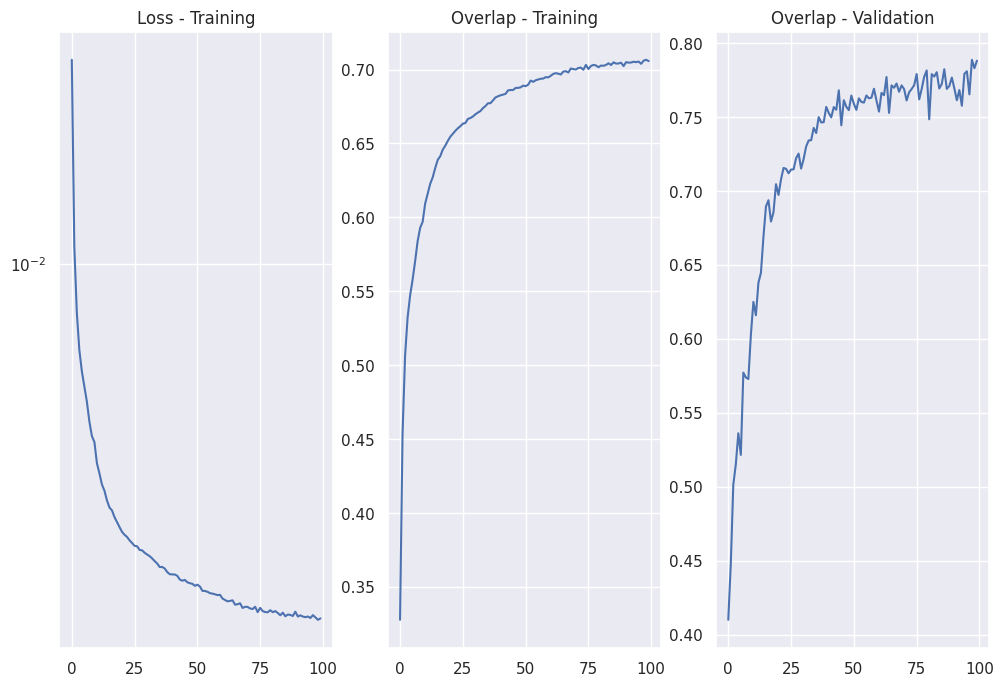

In [27]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.plot(range(len(history.history['loss'])),history.history['loss'])
ax0.set_yscale("log")
ax0.set_title("Loss - Training")
ax1.plot(range(len(history.history['overlap_metric'])),history.history['overlap_metric'])
ax1.set_title("Overlap - Training")
ax2.plot(range(len(history.history['val_overlap_metric'])),history.history['val_overlap_metric'])
ax2.set_title("Overlap - Validation")

## Save / Load model here

Options:

a) To train the model, save it, and test performance (normal use): run all cells above and continue

b) To train the model, skip saving, and test performance: run all cells above and skip the next one, before continuing

c) To load a pre-trained model: start here (i.e. skip training) and continue

In [28]:
# Directory where NN model will be saved
save_dir_root = "/content/drive/My Drive/proj_bma_drive/models/test/"

if model: # Save model
  datestamp = str(datetime.date.today())
  model.export(os.path.join(save_dir_root, datestamp))
  print("Model saved")
else: #Load model (most recent)
  newest_model_path = sorted(glob.glob(os.path.join(save_dir_root, "*-*-*")))[-1]
  model = tf.keras.models.load_model(newest_model_path, custom_objects={"overlap_metric": overlap_metric})
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=0.01),
      loss='mse',
      metrics=['mae', overlap_metric]
      )
  print("Model loaded from", newest_model_path)

Saved artifact at '/content/drive/My Drive/proj_bma_drive/models/test/2024-11-29'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134764141454512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765337157600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765362350912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765471831264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765471835664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765471610512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765472851296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134765471081648: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved


## Compute model performance statistics

Test how well a trained model predicts the bone marrow location in the simulated data.

### Predict using the model

In [29]:

def get_bone_marrow_intensities(x, y):
      """
      Compute the bone marrow intensity for each vertex. The rows of inputs are
      vertices.

      The bone marrow intensity is defined as the average intensity in the layers
      predicted as bone marrow. y can be either predictions or truth. Returns
      a one dimensional array with an intensity for each vertex.
      """
      # Get normalised layer boundaries; if 50 layers, then normalised truth
      # label for layer 1 is 1/50=0.02, for layer 2 it's 2/50, etc.
      layer_number = np.reshape(np.arange(1, nbLayers+1), (1, -1))

      y_denorm = y * nbLayers

      # Array containing True if the value is in bone marrow, false otherwise.
      # Shape is (nbVertices, nbLayers)
      in_bm_bool_array = ((layer_number >= (y_denorm[:,2:3] - 0.5)) &
                          (layer_number <  (y_denorm[:,3:4] + 0.5)))
      # Count number of layers in the BM per vertex, to use as denominator in
      # mean = IntSum / nLayers
      num_layers_bm_per_vertex = np.maximum(np.sum(in_bm_bool_array, axis=1), 1)
      # Get intensity sums counting only BM values, setting all others to 0
      intensity_bm = np.where(in_bm_bool_array, x[:,0:nbLayers], 0)
      intensity_sum_bm = np.sum(intensity_bm, axis=1)
      return intensity_sum_bm / num_layers_bm_per_vertex


def get_bone_marrow_intensities2(x, y):
    """
    Alternative version to check the main implementation.
    Slow, but actually not much difference.
    """
    y_round = np.round(y * nbLayers)
    result = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
      start = int(y_round[i,2]) - 1
      end = int(y_round[i,3]) - 1
      intensity_sum = sum(x[i,start:end])
      result[i] = intensity_sum / max(end - start, 1)
    return result

In [30]:
#--------------- Run the model on different types of head -------------------
# By BMadiposity, size, body adiposity
# We expect NN performance to depend on head type.

bmas = []
sizes = []
adips = []
overlaps = []
intensity_ratios = []

long_df_parts = []

for bounds_file, intensities_file in zip(bounds_files, intensities_files):
    print(bounds_file)
    test_y = np.loadtxt(bounds_file)
    test_x = get_intensities_and_aggregates(np.loadtxt(intensities_file))
    values = model.evaluate(test_x, test_y, return_dict=True)
    m = re.search(r"/size(.*)-bma(.*)-adip(.*)_boundsTrueNorm.tab$", bounds_file)
    size, bma, adip = [float(x) for x in m.groups()]
    overlap = values["overlap_metric"]
    overlaps.append(overlap)
    bmas.append(bma)
    sizes.append(size)
    adips.append(adip)

    preds = model.predict(test_x)
    vertex_overlap = overlap_metric(test_y.astype(np.float32), preds.astype(np.float32))
    # The model's reported overlap metric is the mean of the overlaps for all vertices
    #print('Vertex overlap mean:', np.mean(vertex_overlap), '| evaluate() overlap:', overlap)

    true_bm_intensity = get_bone_marrow_intensities(test_x, test_y)
    pred_bm_intensity = get_bone_marrow_intensities(test_x, preds)
    #pred_bm_intensity2 = get_bone_marrow_intensities2(test_x, preds)
    print(np.sum(pred_bm_intensity))
    #print(np.sum(pred_bm_intensity2))
    #print(np.sum((true_bm_intensity2 - true_bm_intensity) / true_bm_intensity))
    #print(true_bm_intensity.size)

    intensity_ratios.append(np.mean(pred_bm_intensity / true_bm_intensity))

    common_pars = {"BMA": bma, "Size": size, "Adip": adip, "Overlap": vertex_overlap}
    stats = [
            ("FirstBound", test_y[:,2]*nbLayers, preds[:,2]*nbLayers),
            ("SecondBound", test_y[:,3]*nbLayers, preds[:,3]*nbLayers),
            ("Intensity", true_bm_intensity, pred_bm_intensity),
            ("Thickness", (test_y[:,3]-test_y[:,2])*nbLayers+1,
                          (preds[:,3]-preds[:,2])*nbLayers+1),
            ]
    long_df_parts.append(pd.DataFrame(
        dict({"DataClass":"True"},
             **{x[0]: x[1] for x in stats},
             **common_pars))
    )
    long_df_parts.append(pd.DataFrame(
        dict({"DataClass":"Predicted"},
             **{x[0]: x[2] for x in stats},
             **common_pars))
    )
    long_df_parts.append(pd.DataFrame(
        dict({"DataClass":"Ratio"},
             **{x[0]: x[2]/x[1] for x in stats},
             **common_pars))
    )
    long_df_parts.append(pd.DataFrame(
        dict({"DataClass":"Difference"},
             **{x[0]: x[2]-x[1] for x in stats},
             **common_pars))
    )

# Data frames containing all the performance data
# Vertex-level data
long_df = pd.concat(long_df_parts)
# Head-level data
df = pd.DataFrame({'IntensityRatio': intensity_ratios, 'Overlap': overlaps,
                  'BMA': bmas, 'Adip':adips, 'Size':sizes})

# Following code: de-normalises the predicted bounds (converts range [0,1] to [1,50])
# This is useful if want to plot the predicted bounds (for the simulated data)
#preds = model.predict(test_x, batch_size=None)
#preds = preds * nbLayers # De-normalise predicted bounds
#for pred in preds:
#  np.clip(pred,a_min=1, a_max=nbLayers, out=pred) # de-normalisation may produce out-of-range bounds, force defined range [1,50]
#np.savetxt("/content/drive/My Drive/simulData50/" + str(adip) + "_bounds_NN.txt", preds, fmt="%d")


/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.6-bma110-adip0.3_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - mae: 0.0583 - overlap_metric: 0.4328
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1522.9554765826947
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.6-bma110-adip0.5_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mae: 0.0474 - overlap_metric: 0.5174
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1600.6795238744694
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.6-bma110-adip0.7_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - mae: 0.0403 - overlap_metric: 0.5684
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1641.6298610581687
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.6-bma110-adip1.5_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0289 - overlap_metric: 0.6687
157/157 ━━━━━━━━━━━━━━━━

<ipython-input-30-b2fe5eb26340>:39: RuntimeWarning: invalid value encountered in divide
  intensity_ratios.append(np.mean(pred_bm_intensity / true_bm_intensity))
<ipython-input-30-b2fe5eb26340>:61: RuntimeWarning: invalid value encountered in divide
  **{x[0]: x[2]/x[1] for x in stats},


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0321 - overlap_metric: 0.6465
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
769.798391279011
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.8-bma40-adip2_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - mae: 0.0346 - overlap_metric: 0.6441
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
764.5427314331339
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.8-bma40-adip3_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0385 - overlap_metric: 0.6136
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
780.9991165895553
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.8-bma40-adip4_boundsTrueNorm.tab
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mae: 0.0427 - overlap_metric: 0.5736
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
800.7117183499465
/content/drive/My Drive/proj_bma_drive/code_v1.2_simulData50a/size0.8-bma50-adip0.

### Summary statistics used in supplementary materials

<Axes: xlabel='Overlap', ylabel='IntensityRatio'>

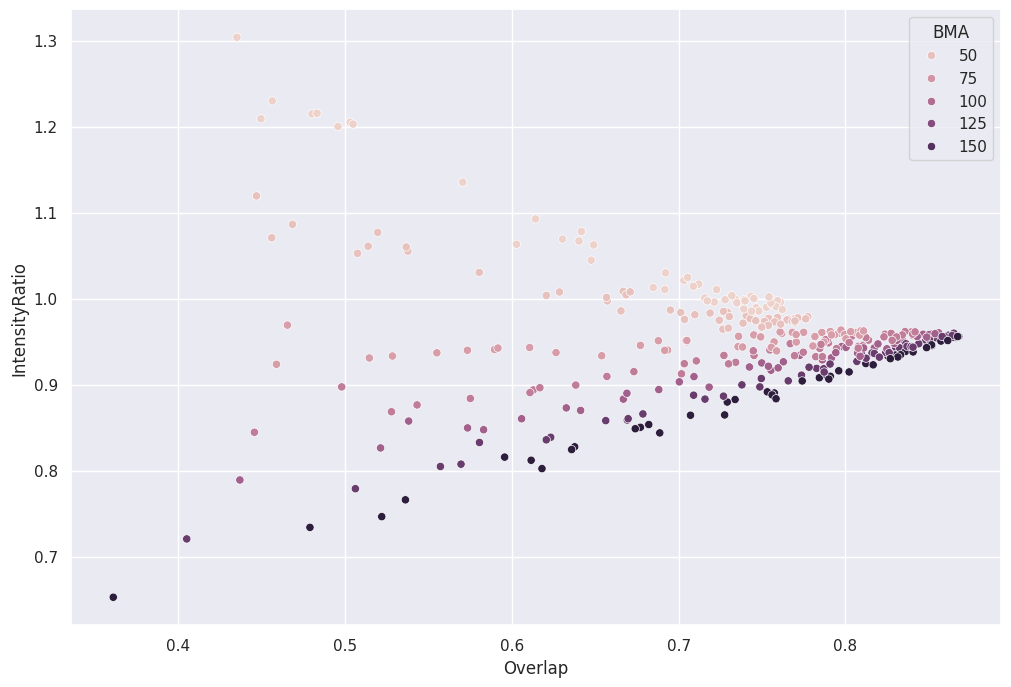

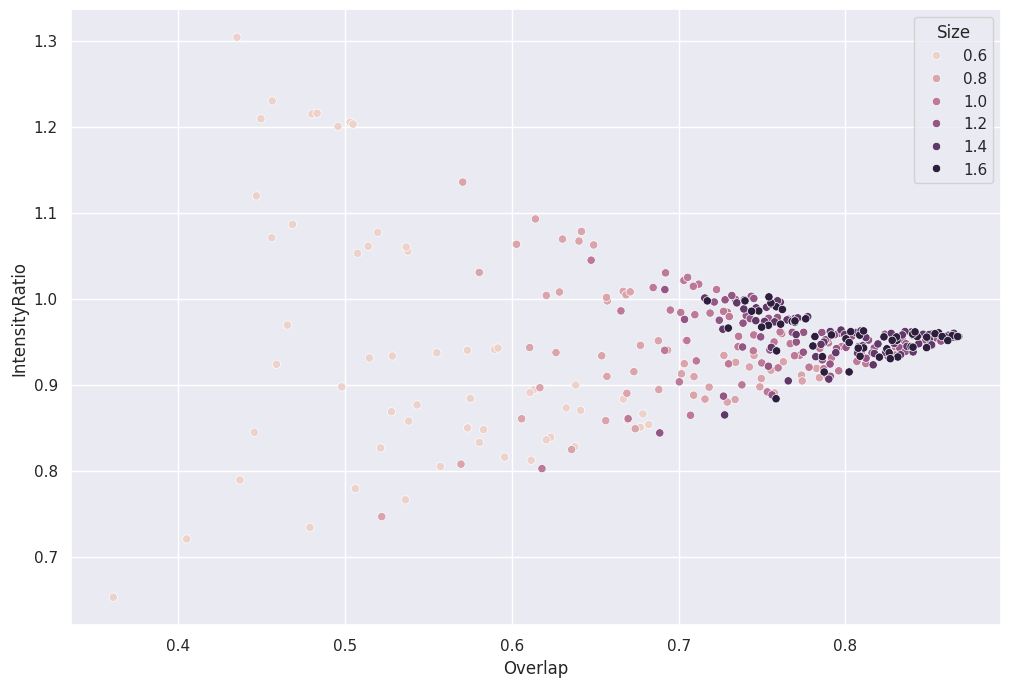

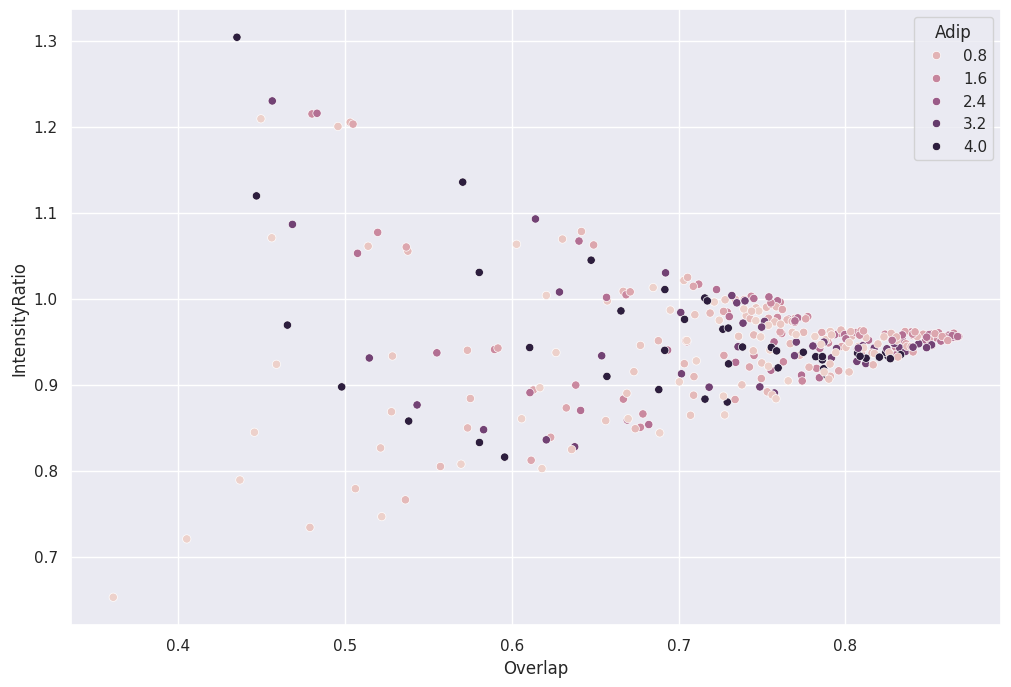

In [31]:
# Plotting the same data as above, but with the intensityRatio against the intensityRatio
# IntensityRatio is what matters in practive. We want this to be as close to 1 as possible.

# Plotting overlap (x) vs intensity ratio (y)
# Colour by variables adiposities, scales, bodyAdips

# Instead of using the below scatterplot function, we need to use regplot
# (regression plot) because jitter is not implemented in Seaborn's scatterplot()
plt.figure()
sns.scatterplot(data=df, x='Overlap', y='IntensityRatio', hue='BMA')
plt.figure()
sns.scatterplot(data=df, x='Overlap', y='IntensityRatio', hue='Size')
plt.figure()
sns.scatterplot(data=df, x='Overlap', y='IntensityRatio', hue='Adip')

#sns.regplot(data=df, x='Overlap', y='IntensityRatio', color='Adiposity', ax=ax1,
#            fit_reg=False, y_scatter=True, x_scatter=True)

### Saving performance metrics for simulated data



In [32]:
# Save the data frame of head-level aggregates
# We need these data to make ggplot2 versions of the plots for the supplementary materials.
nnPerfMetricsFile='/content/drive/My Drive/proj_bma_drive/simulatedHeads_nnPerformance_forPlotting_test1.csv'

df.to_csv(nnPerfMetricsFile)

# Quick check on file contents
print("Row count:", len(df))
df.head()

Row count: 336


,IntensityRatio,Overlap,BMA,Adip,Size
0,0.789098,0.436928,110.0,0.3,0.6
1,0.826333,0.521301,110.0,0.5,0.6
2,0.849621,0.573465,110.0,0.7,0.6
3,0.883087,0.666873,110.0,1.5,0.6
4,0.872898,0.632654,110.0,1.0,0.6
